## Configuration

In [13]:
import pandas as pd

In [14]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_merged_dataset, get_e_price_dataset, standardize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_return_mae, predict_return_mse
from src.plot import plot_merged_datasets, feature_importance, plot_predicted

In [15]:
price_interval, prediction_date_picker, eval_size =  get_config_widgets()

IntRangeSlider(value=(-74, 222), continuous_update=False, description='Energy Price Interval', max=900, min=-4…

DatePicker(value=None, description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

## Data loading

In [16]:
merged_df = get_merged_dataset()
e_price_df = get_e_price_dataset()

min_price, max_price = price_interval.value

merged_ex_out_df = merged_df.copy()[
    (merged_df['Price'] >= min_price) &
    (merged_df['Price'] <= max_price)
]

e_price_ex_out_df = merged_df.copy()[
    (merged_df['Price'] >= min_price) &
    (merged_df['Price'] <= max_price)
]

z_merged_df, z_actual_price_df, actual_price_scaler = standardize_data(merged_df.copy(), e_price_df.copy())
z_merged_ex_out_df, z_actual_ex_out_price_df, actual_price_ex_out_scaler = standardize_data(merged_ex_out_df.copy(), e_price_ex_out_df.copy())



## Feature Selection

In [17]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [18]:
selected_features = get_features()

FEATURES =  default_features if not selected_features else selected_features

TARGET = merged_df["Price"]

features_df = create_features(merged_df)[FEATURES]
combined_df = pd.concat([features_df, TARGET], axis=1)
train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value)

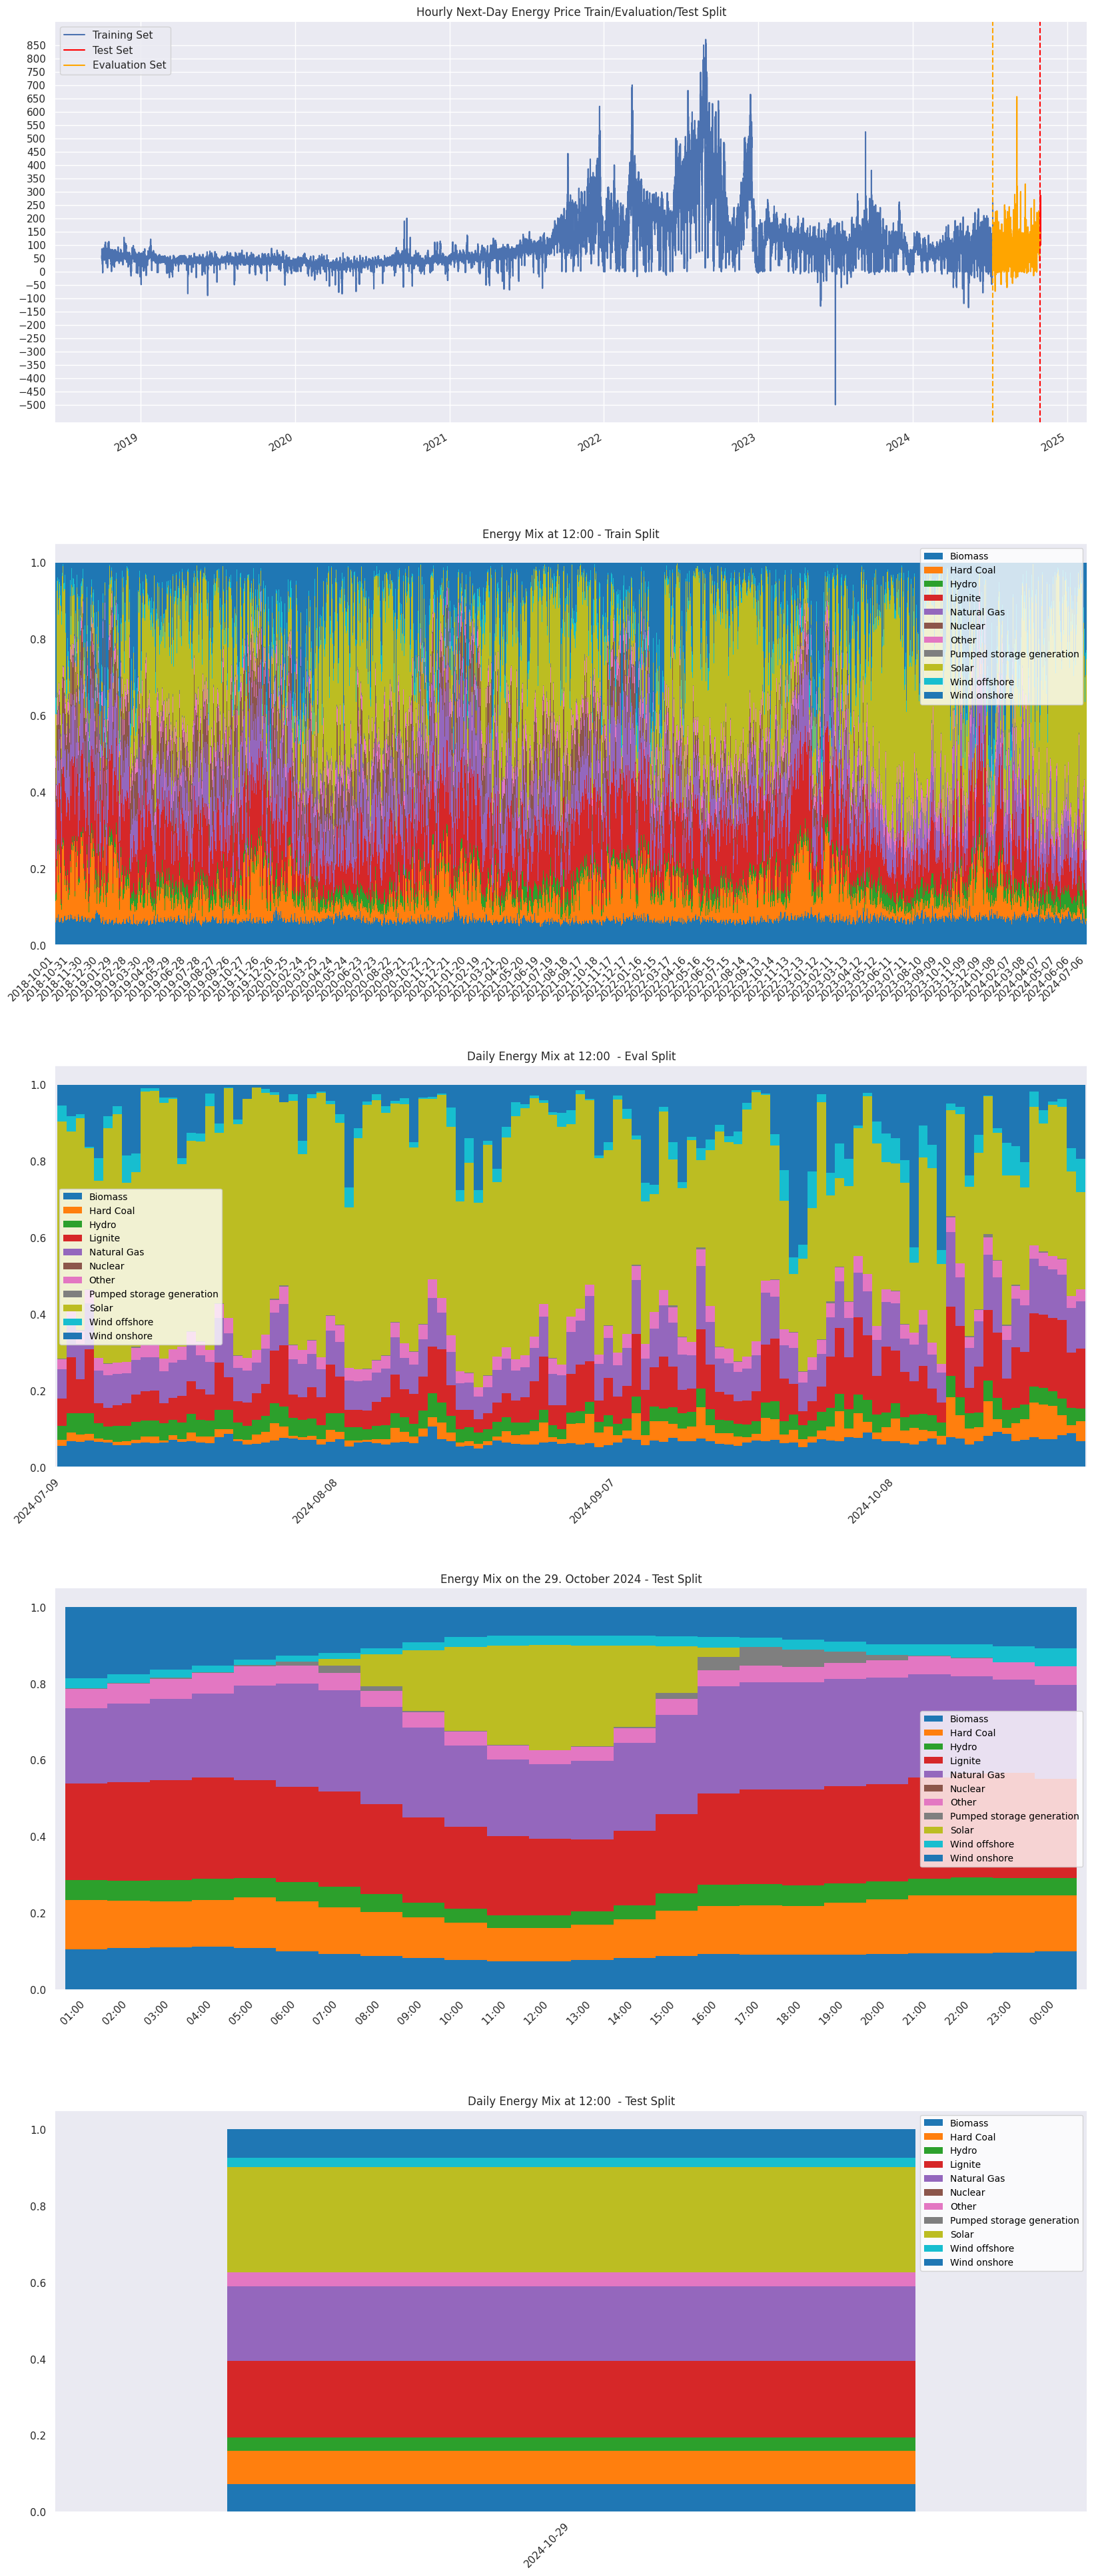

In [19]:
plot_merged_datasets(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST)

In [20]:
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

## Prediction

### Linear Regression

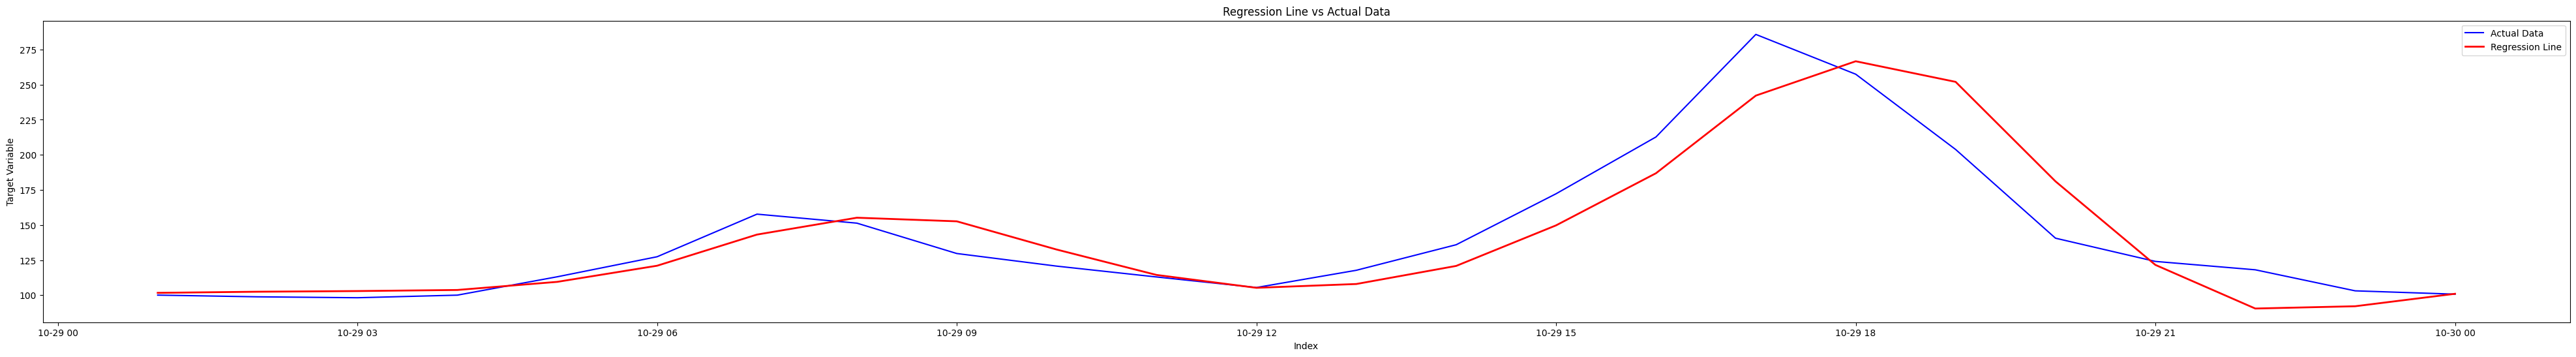

Root Mean Squared Error: 19.72131795309189
R-squared: 0.8442773063427089


In [21]:
linear_regression(X_train, y_train, X_test, y_test)

### Prophet

### XGBoost

In [ ]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
y_predicted_mse, model_mse = predict_return_mse(best_params, X_train, y_train, X_val, y_val, X_test)
y_predicted_mae, model_mae = predict_return_mae(best_params, X_train, y_train, X_val, y_val, X_test)

[0]	validation_0-rmse:87.01272
[25]	validation_0-rmse:22.91961
[50]	validation_0-rmse:12.68357
[75]	validation_0-rmse:11.38793
[100]	validation_0-rmse:11.09659
[125]	validation_0-rmse:10.98154
[149]	validation_0-rmse:10.91657
[0]	validation_0-mae:75.32006
[25]	validation_0-mae:17.10485
[50]	validation_0-mae:7.18715
[75]	validation_0-mae:6.09672
[100]	validation_0-mae:5.95519
[125]	validation_0-mae:5.94091


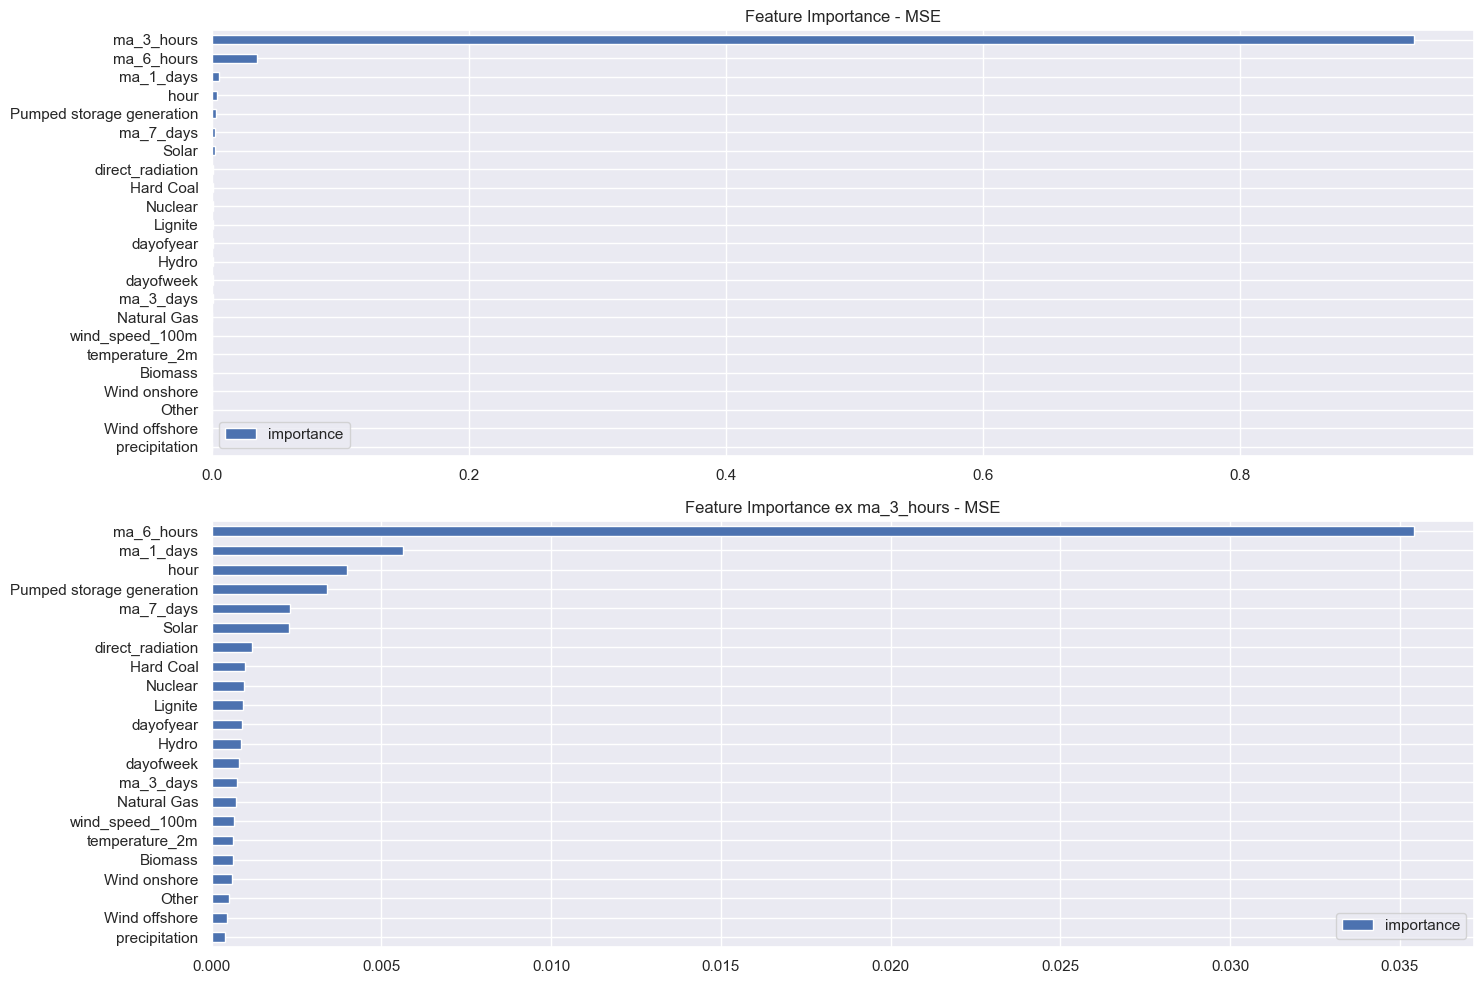

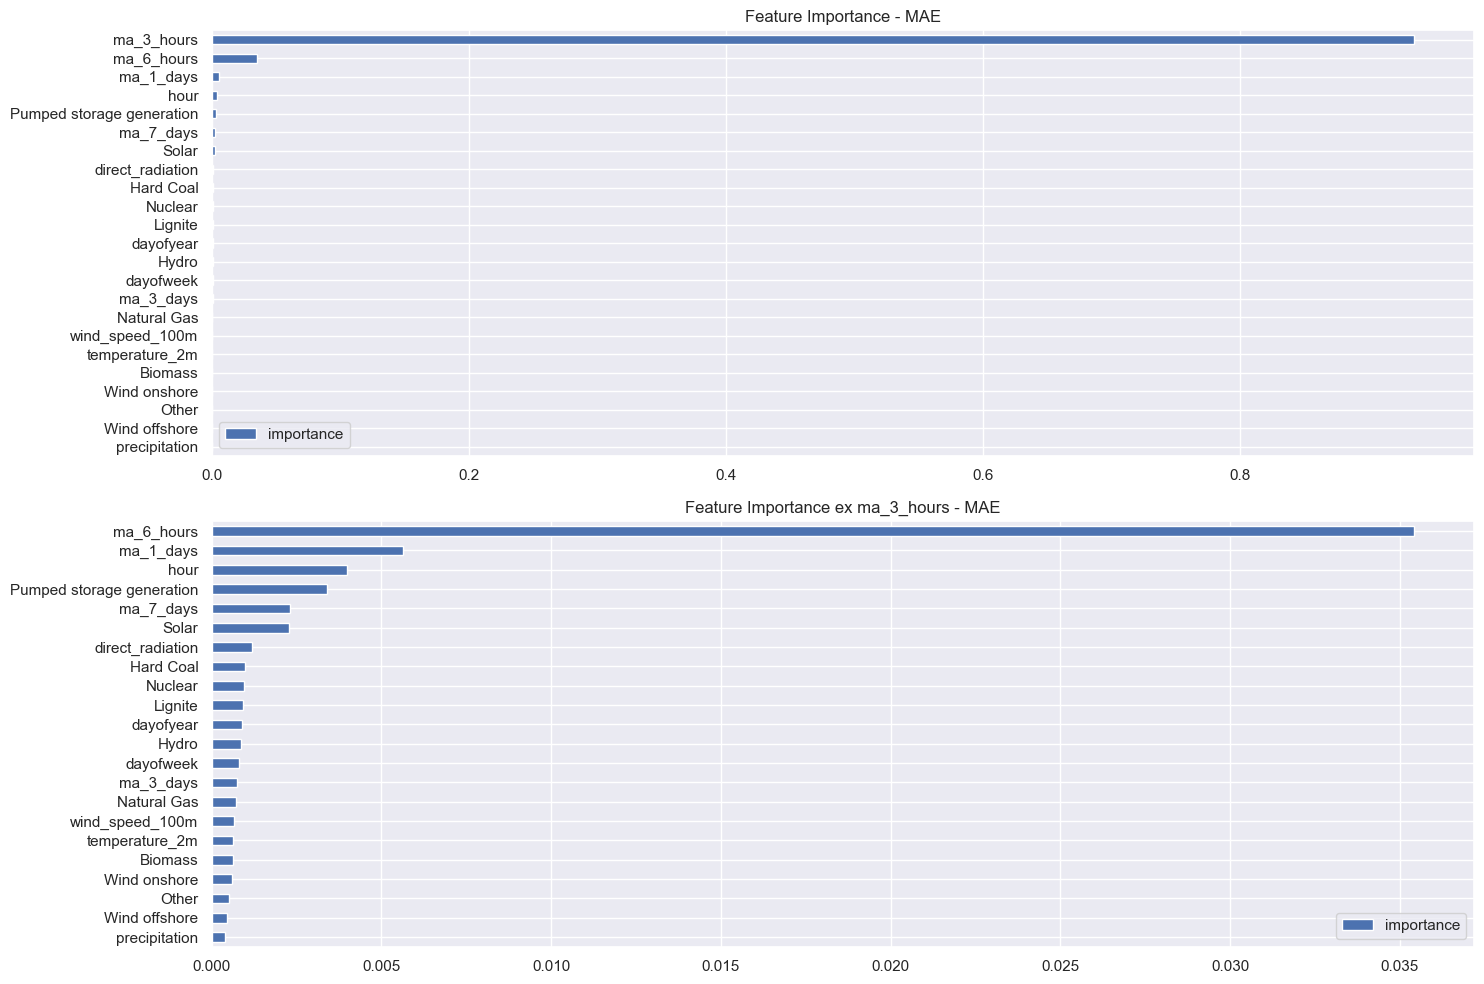

In [ ]:
feature_importance(model_mse, "MSE")
feature_importance(model_mae, "MAE")

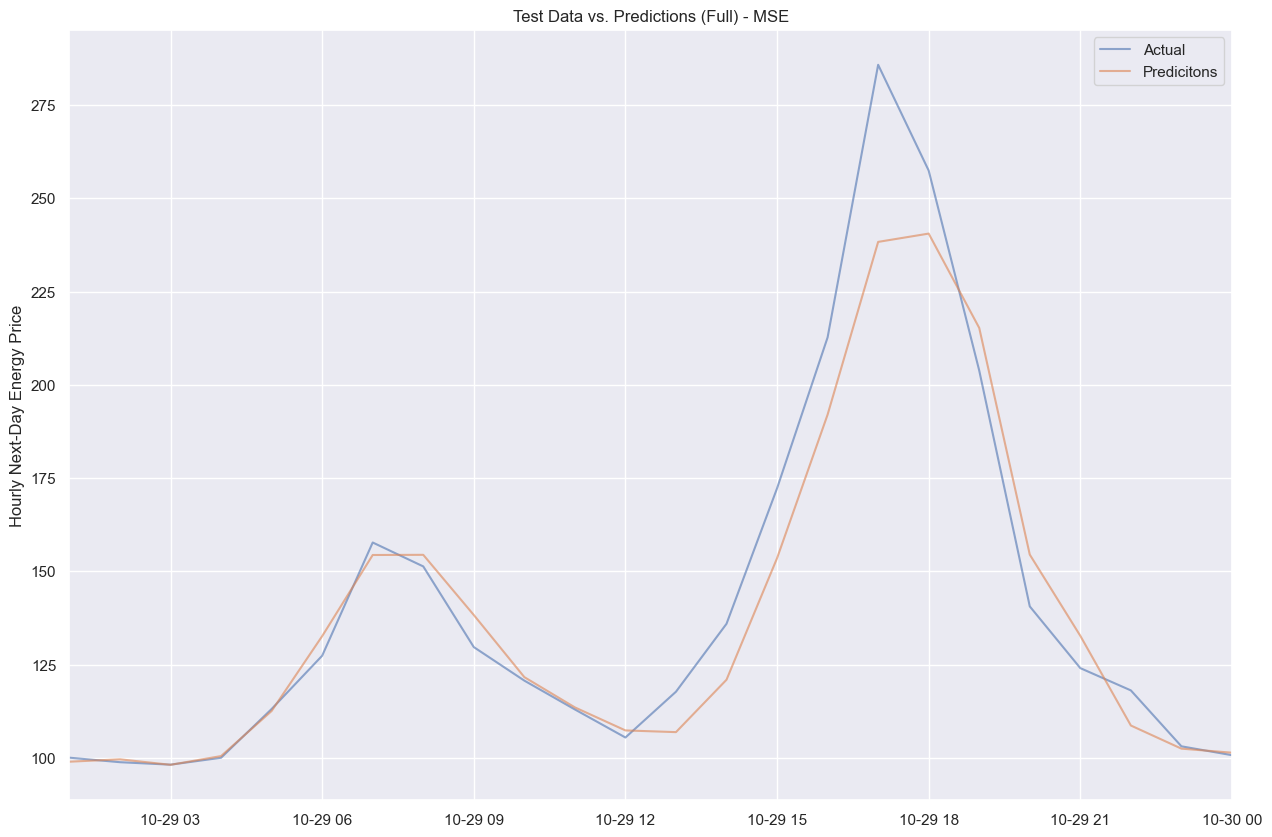

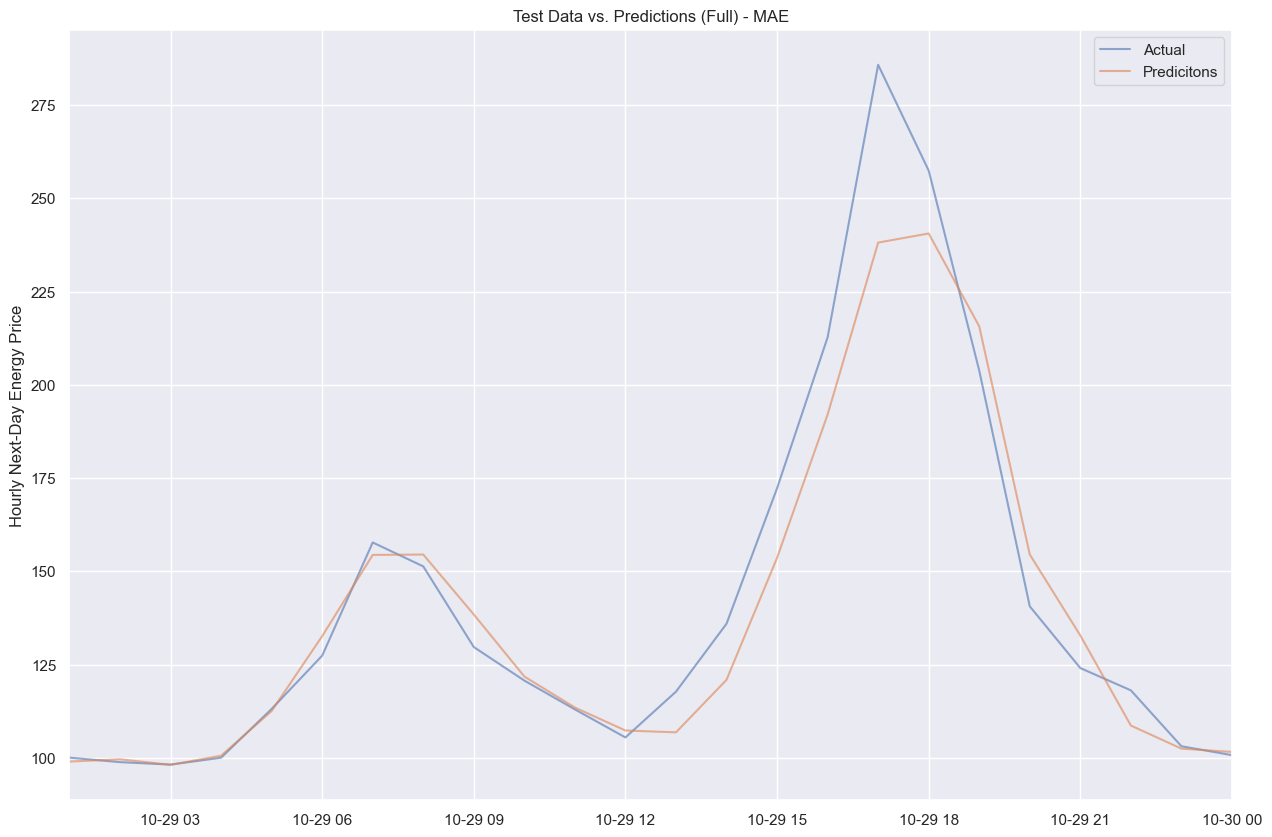

In [ ]:
for predictions, objective_name in [(y_predicted_mse, "MSE"), (y_predicted_mae, "MAE")]:
    plot_predicted(test, predictions, objective_name)

# buf = io.BytesIO()
# plt.savefig(buf, format='png')
# plt.show()
# plt.close()
# buf.seek(0)

# ts_image = Image.open(buf)

## Results